In [1]:
#Importing relevant packages and King county data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import itertools
from numbers import Number
from scipy import stats
import statsmodels.api as sm
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
from sklearn.dummy import DummyRegressor
%matplotlib inline


df = pd.read_csv("data/kc_house_data.csv",parse_dates=['date'], index_col=0)

In [2]:
#Dropping columns that were suggested not to use, except date and zipcode
df.drop(['view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'waterfront'], 
        axis=1, inplace=True)


#Creating price per square foot column
df['price_sqft'] = df['price'] / df['sqft_living']

In [3]:
#Creating map for zipcodes
zip_map = {
    98001:'Suburbs', 98002:'Suburbs', 98003:'Suburbs', 98004:'Suburbs', 98005:'Suburbs',
    98006:'Suburbs', 98007:'Suburbs',98008:'Suburbs', 98010:'Rural', 98011:'Suburbs', 
    98014:'Rural', 98019:'Rural', 98022:'Rural', 98023:'Suburbs', 98024:'Rural', 
    98027:'Rural', 98028:'Suburbs', 98029:'Suburbs', 98030:'Suburbs', 98031:'Suburbs',
    98032:'Suburbs', 98033:'Suburbs', 98034:'Suburbs', 98038:'Rural', 98039:'Suburbs',
    98040:'Suburbs', 98042:'Rural', 98045:'Rural', 98052:'Suburbs', 98053:'Rural',
    98055:'Suburbs', 98056:'Suburbs', 98058:'Suburbs', 98059:'Suburbs', 98065:'Rural',
    98070:'Suburbs', 98072:'Suburbs', 98074:'Suburbs', 98075:'Suburbs', 98077:'Rural',
    98092:'Suburbs', 98102:'Seattle', 98103:'Seattle', 98105:'Seattle', 98106:'Seattle',
    98107:'Seattle', 98108:'Seattle', 98109:'Seattle', 98112:'Seattle', 98115:'Seattle', 
    98116:'Seattle', 98117:'Seattle', 98118:'Seattle', 98119:'Seattle', 98122:'Seattle',
    98125:'Seattle', 98126:'Seattle', 98133:'Seattle', 98136:'Seattle', 98144:'Seattle', 
    98146:'Seattle', 98148:'Seattle', 98155:'Seattle', 98166:'Seattle', 98168:'Seattle',
    98177:'Seattle', 98178:'Seattle', 98188:'Seattle', 98198:'Seattle', 98199:'Seattle'
    }

#creating a map for condition since there are low values of Poor and Fair compared to the other categorical variables
condition_map = {
                 'Poor': 0,
                 'Fair': 1,
                 'Average': 2,
                 'Good': 3,
                 'Very Good': 4
                }

#mapping grade map
grade_map = {
             '3 Poor': 3,
             '4 Low': 4,
             '5 Fair': 5,
             '6 Low Average': 6,
             '7 Average': 7,
             '8 Good': 8,
             '9 Better': 9,
             '10 Very Good': 10,
             '11 Excellent': 11,
             '12 Luxury': 12,
             '13 Mansion': 13
            }

# Adding maps to dataframe & dropping columns that were mapped
df['zones'] = df['zipcode'].map(zip_map)
df.drop('zipcode', axis=1, inplace=True);
df['cond_num'] = df['condition'].map(condition_map)
df.drop('condition', axis = 1, inplace=True);
df['grade_num'] = df['grade'].map(grade_map)
df.drop('grade', axis = 1, inplace=True);

Sorted zipcodes with following sources
- website =  https://www.unitedstateszipcodes.org/wa/ 
- map = https://aqua.kingcounty.gov/gis/web/VMC/boundaries/zipcodes/zipcodes.pdf

# Things to do for Model
- Standard Scaler
- linear regression 

In [4]:
#Dummymodel creation and evaluation
dummymodel = DummyRegressor(strategy = "mean")
X = df.drop(columns ='price', axis = 1)
y = df['price']
dummymodel = dummymodel.fit(X, y)

dummymodel.predict(X)
dummymodel.predict(y)
dummymodel.score(X, y)

0.0

# Ordinal & One Hot Encoder
Can do OrdinalEncoder directly on condition and grade but might be better to bin them since there are a fair amount of unique values for both which could cause multicollinearlity.

For condition:

- Poor
- Fair
- Average
- Good
- Very Good


For grade:

- 7 Average
- 8 Good
- 9 Better
- 6 Low Average
- 10 Very Good
- 11 Excellent
- 5 Fair
- 12 Luxury
- 4 Low
- 13 Mansion
- 3 Poor

Zipcode:
- Rural
- Suburbs
- Seattle

In [5]:
#defining X & y
X = df.drop(columns='price', axis=1)
y = df['price']

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#creating a train df and test df
train_kch = pd.concat([X_train, y_train], axis=1)
test_kch = pd.concat([X_test, y_test], axis=1)

In [6]:
#Creating variables storing our Ordinal & One Hot Encoding columns
train_kch_cat = train_kch[['cond_num', 'grade_num']]
train_kch_zones = train_kch[['zones']] 
test_kch_cat = test_kch[['cond_num', 'grade_num']]
test_kch_zones = test_kch[['zones']]

#Initializing Ordinal and One Hot
ore = OrdinalEncoder()
ore.fit(train_kch_cat)
ohe = OneHotEncoder()
ohe.fit(train_kch_zones)


#Applying Ordinal and One Hot to our Train and Test
ohe_transform = ohe.transform(train_kch_zones)
zones_encoded = pd.DataFrame(ohe_transform, columns =['zones'], 
                           index= train_kch_zones.index)

ohe_test_transform = ohe.transform(test_kch_zones)
zones_encoded_test = pd.DataFrame(ohe_test_transform, columns =['zones'],
                          index= test_kch_zones.index)

ore_transform = ore.transform(train_kch_cat)
cat_encoded = pd.DataFrame(ore_transform, columns = ['cond_num_cat','grade_num_cat'], 
                          index=train_kch_cat.index)

ore_test_transform = ore.transform(test_kch_cat)
cat_encoded_test = pd.DataFrame(ore_test_transform, columns = ['cond_num_cat','grade_num_cat'], 
                          index=test_kch_cat.index)



# Standard Scaling

In [7]:
#standard scaling the numerical values dropping categorical and target 
#training data
X_train_kch_nums = train_kch.drop(['cond_num', 'grade_num', 
                                   'zones','date', 'price'], axis=1)
y_train_kch = train_kch['price']

#testing data
X_test_kch_nums = test_kch.drop(['cond_num','grade_num', 
                                'zones','date', 'price'], axis=1)
y_test_kch = test_kch['price']

#Standardized Scaler - fit to training x
ss = StandardScaler().fit(X_train_kch_nums)

#training data - transform
X_train_scaled = pd.DataFrame(ss.transform(X_train_kch_nums), columns=X_train_kch_nums.columns, index=X_train_kch_nums.index)


#testing data - transform
X_test_scaled = pd.DataFrame(ss.transform(X_test_kch_nums), columns=X_test_kch_nums.columns, index=X_test_kch_nums.index)

In [8]:
#now can join the two separate variables - standardized and numerical
train_kch = pd.concat([X_train_scaled, cat_encoded, zones_encoded, y_train_kch],axis=1)

# Linear & Multilinear Regression

In [9]:
#Initializing LinearRegression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_kch)

LinearRegression()

In [10]:
lr.coef_

array([ -3827.43294489,  15885.83924002, 275324.80577021,  -9194.22221413,
        -9601.6626288 ,  -3407.5311024 , 229873.74813297])

In [11]:
lr.intercept_

541519.0094345082

In [12]:
lr.score(X_train_scaled, y_train_kch)

0.8826148053074151

In [13]:
#Here is our first model, just a simple linear regression between price and square feet
# I want to try and bring the R2 value up more

y2 = df['price']
X_baseline = df['sqft_living']

baseline_model = sm.OLS(y2, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

baseline_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Tue, 13 Sep 2022   Prob (F-statistic):               0.00
Time:                        14:27:47   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
#here is our second model where I try and add the 2nd highest correlated value to the model to see if I can bring R2 up
#It appears to not have worked
x_2 = df[['sqft_living', 'bathrooms']]
x_2

second_model = sm.OLS(y, sm.add_constant(x_2))
second_results = second_model.fit()

second_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 1.049e+04
Date:                Tue, 13 Sep 2022   Prob (F-statistic):               0.00
Time:                        14:27:48   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21594   BIC:                         6.002e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.992e+04   5237.187     -7.622      0.000   -5.02e+04   -2.97e+04
sqft_living   284.0883      2.962     95.926      0.000     278.284     289.893
bathrooms   -5095.2734   3535.830     -1.441      0.150    -1.2e+04    1835.215
==============================================================================
Omnibus:                    14783.268   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           540478.758
Skew:                           2.815   Prob(JB):                         0.00
Kurtosis:                      26.852   Cond. No.                     7.27e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
#So here is our third model, where we made this after we added our Ordinal and One Hot encoder 
#as well as standized all the numaric values, this performs way better than our first 2 iterations with a R2 of .88
#I think I want to try and improve this with adding our catagorical data ie: grade, condition, and zone

baseline_model2 = sm.OLS(y_train_kch, sm.add_constant(X_train_scaled))
baseline_results2 = baseline_model2.fit()

baseline_results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                 1.855e+04
Date:                Tue, 13 Sep 2022   Prob (F-statistic):               0.00
Time:                        14:27:48   Log-Likelihood:            -2.2747e+05
No. Observations:               17277   AIC:                         4.550e+05
Df Residuals:                   17269   BIC:                         4.550e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.415e+05    961.945    562.942      0.000     5.4e+05    5.43e+05
bedrooms    -3827.4329   1256.818     -3.045      0.002   -6290.924   -1363.942
bathrooms    1.589e+04   1724.473      9.212      0.000    1.25e+04    1.93e+04
sqft_living  2.753e+05   1608.958    171.120      0.000    2.72e+05    2.78e+05
sqft_lot    -9194.2222    986.680     -9.318      0.000   -1.11e+04   -7260.230
floors      -9601.6626   1191.191     -8.061      0.000   -1.19e+04   -7266.807
yr_built    -3407.5311   1265.162     -2.693      0.007   -5887.376    -927.686
price_sqft   2.299e+05   1055.613    217.763      0.000    2.28e+05    2.32e+05
==============================================================================
Omnibus:                    16143.352   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4348861.236
Skew:                           3.839   Prob(JB):                         0.00
Kurtosis:                      80.344   Cond. No.                         3.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Evaluate Performance

In [16]:
y_hat= lr.predict(X_train_scaled)
y_hat

array([267339.72759972, 366273.58286976, 835719.1324698 , ...,
       227460.79599347, 815352.76930294, 598402.95934323])

In [17]:
resid=(y_train_kch - y_hat)
resid

id
9834201100     65160.272400
7795810110     23726.417130
1853081250    -35719.132470
2558630350     -4944.830279
3362401000     -7697.421255
                  ...      
7853230570     -5008.656285
4140940150    -54431.841956
8658300480     72339.204007
1723049033   -570352.769303
8567450080    -53402.959343
Name: price, Length: 17277, dtype: float64

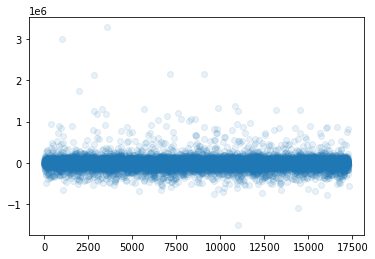

In [18]:
fig, ax  =plt.subplots()
ax.scatter(x=range(y_hat.shape[0]), y=resid, alpha=.1);

In [19]:
pricecorr = df.corr()['price']
pricecorr.abs().sort_values(ascending=False)[1:]

sqft_living    0.701917
grade_num      0.667951
price_sqft     0.556056
bathrooms      0.525906
bedrooms       0.308787
floors         0.256804
sqft_lot       0.089876
yr_built       0.053953
cond_num       0.036056
Name: price, dtype: float64

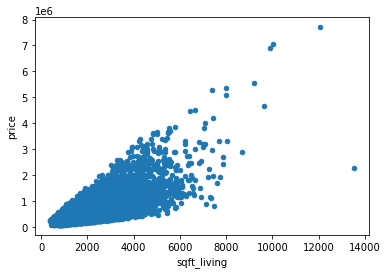

In [20]:
df.plot.scatter(x='sqft_living', y='price');

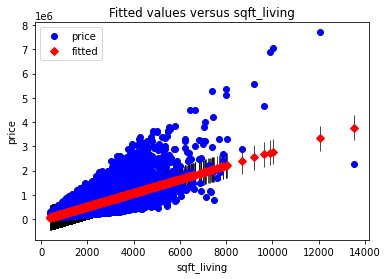

In [21]:
sm.graphics.plot_fit(baseline_results, "sqft_living")
plt.show()

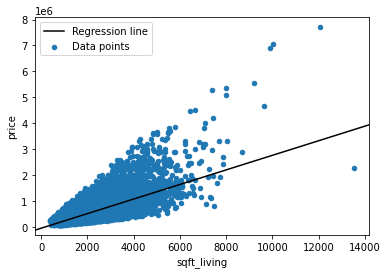

In [22]:
fig, ax = plt.subplots()
df.plot.scatter(x="sqft_living", y="price", label="Data points", ax=ax)
sm.graphics.abline_plot(model_results=baseline_results, label="Regression line", ax=ax, color="black")
ax.legend();

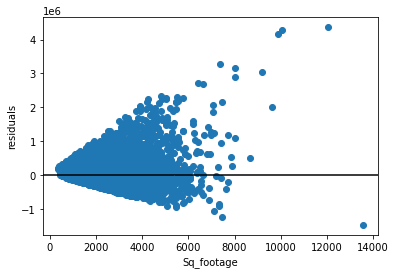

In [23]:
fig, ax = plt.subplots()

ax.scatter(df["sqft_living"], baseline_results.resid)
ax.axhline(y=0, color="black")
ax.set_xlabel("Sq_footage")
ax.set_ylabel("residuals");

# Visualizations 

- mean price per square foot in each zone for a average house

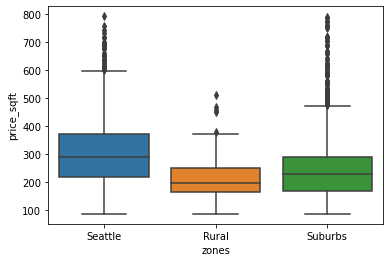

In [27]:
sns.boxplot(x=test_kch['zones'], y=test_kch['price_sqft']);
plt.show()